In [1]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline  

import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
from IPython.core.display import display, HTML
print "... ready"

... ready


In [2]:
# 'headerlist.txt' lists all columns
# 'drop.txt' indicates which ones are being used and whether they're numeric or binary

f = open('headerlist.txt', 'r')
headerlist = f.read().rstrip('\n').split(',')
droplist = pd.read_csv('drop.txt', dtype='unicode', names=['name', 'action', 'type'])
keeplist = droplist[droplist.action == 'keep']
droplist = droplist[droplist.action == 'drop']['name'].tolist()

data = pd.read_csv('correlatesofstatepolicyprojectv1_10.csv', dtype='unicode', names=headerlist, encoding = 'utf8')
data.drop(0, inplace=True) # header row
data = data[data.st != 'DC'] # taking DC out of the data, because so much of it is missing
print "... ready"

... ready


In [3]:

#def match_policy(policy, data):
#    ab = data[data[policy].notnull()][['year', 'st', policy]]
#    ab.set_index('year', inplace=True)
#    ab[policy] = ab[policy].astype('float')
#    policyframe=ab[ab[policy] > 0]
#    return policyframe

def policy_table(policy, action):
    data[policy] = data[policy].astype('float')
    cs = data[['year', 'st', policy]]
    if action == 'adoption':
        policy_table = cs[cs[policy] == 1].groupby('st').nth(0).head(1000).sort_values('year')
    elif action == 'repeal':
        policy_table = cs[cs[policy] == 1].groupby('st').last().head(1000).sort_values('year')
    policy_table.reset_index(inplace=True)
    return policy_table

def numeric_pivot(c):
    table = data[['st', 'year', c]]
    ptable = table.pivot(index='year', columns='st', values=c)
    ptable=ptable.dropna(how='any',axis=0)
    ptable = ptable.astype('float')
    ptable['national_average'] = ptable.mean(axis=1)
    return ptable

def browntext(text):
    display (HTML("<font color=\"brown\">"+text+"</fond>"))
print "... ready"

... ready


In [4]:
print "\n                   ***** WRANGLING and CLEANING UP ******\n"

print "|   The data consists of numeric columns such as population and income as well as "
print "|   policy columns indicating things like whether and when women were allowed"
print "|   to serve on juries. It also includes the makeup of state house representatives"
print "|   and a few other political tidbits, such as how many people know the name of their governor.\n"
print "|   All together, there are ~ 900 indicators, roughly half of which I chose to drop at the outset "
print "|   for being redundant, for not having enough data or for some other reason.  \n"

print "|   The data is presented with a set of rows for each year, for each state.  That gives us"
print "|   (50 states) * (117 years) = 5850 rows\n"

# Which columns show policy actions?
print "\n|   How many policy actions survived the initial purge?\n"
policy_actions = keeplist[keeplist.type == 'bin']
num_bin_policies = len(policy_actions)
print  num_bin_policies 

print "\n|   How many numeric indicators survived the initial purge?\n"
numeric_indicators = keeplist[keeplist.type == 'num']
num_num = len(numeric_indicators)
print  num_num 


                   ***** WRANGLING and CLEANING UP ******

|   The data consists of numeric columns such as population and income as well as 
|   policy columns indicating things like whether and when women were allowed
|   to serve on juries. It also includes the makeup of state house representatives
|   and a few other political tidbits, such as how many people know the name of their governor.

|   All together, there are ~ 900 indicators, roughly half of which I chose to drop at the outset 
|   for being redundant, for not having enough data or for some other reason.  

|   The data is presented with a set of rows for each year, for each state.  That gives us
|   (50 states) * (117 years) = 5850 rows


|   How many policy actions survived the initial purge?

263

|   How many numeric indicators survived the initial purge?

244


In [5]:
print "\n|   In general, the columns have groups of years with data and then nulls before and after."
print "|   Among the years with data, the policy columns have zeros and ones indicating whether "
print "|   the policy is in effect while the numeric columns have numbers indicating values.\n"

print "|   That's very usable.  Nulls at the start and end of a data series can be assumed to not exist"
print "|   and can be left as nulls.  But there seem to be a few instances of null values within the time "
print "|   blocks that are supposed to have data.\n"

print "|   For policy columns (either 0 or 1 if data exists), such as whether or not state taxes are levied"
print "|   in a given year, it's reasonable to fill the gaps using the assumption that the last known value "
print "|   is valid until there's a new one. \n"

print " .... fixing .... \n"

# fixing policy columns
## in truth I had a different function here previously which returned the indicies of 
## missing values that required interpolation.  It turned out that only one column had
## the issue, "income_taxes".  Since that routine was even slower than the one below is,
## and sine I no longer needed it, I removed it.  At the same time, there's no point in
## running this on 263 columns when I know that only one needs it.

for state in data.st.unique():
    #for pa in policy_actions.name:
    for pa in ['income_taxes']:
        if data[pa][data.st == state].count() > 0: # skipping columns that have no data at all
            data[pa]\
                 .iloc[data[pa][data.st == state].first_valid_index()\
                      :data[pa][data.st == state].last_valid_index() - 1]\
                                  .fillna(method='ffill', inplace=True)


print " ... fixed\n"

print "|   But the numeric columns have to be considered individually.  For example, legislative "
print "|   expenditures are only given in odd years.  Filling those gaps could lead to false calculations.\n"
print data[['year', 'leg_expend', 'st']][data.st == 'WY']\
            .iloc[data['leg_expend'].first_valid_index():data['leg_expend'].last_valid_index() + 1].head(12)

print "\n|   For an item like an abortion rate, the data is genuinely missing, but it doesn't seem wise to"
print "|   make assumptions about what it is.  It could be better to know that you don't know in this case.\n"
print data[['year', 'abortionrate', 'st']][data.st == 'AK'].iloc[91:97]

print "\n|   Finally, for a column like female population, it's probably safe to interpolate or simply fill"
print "|   in previous values.\n"
print data[['year', 'popfemale', 'st']][data.st == 'AK']\
            .iloc[data['popfemale'].first_valid_index():data['popfemale'].last_valid_index() + 1].head(12)
    
print "\n .... fixing female populations ....\n"
for state in data.st.unique():
    data['popfemale']\
         .iloc[data['popfemale'][data.st == state].first_valid_index()\
              :data['popfemale'][data.st == state].last_valid_index() + 1]\
                     .fillna(method='ffill', inplace=True)

print data[['year', 'popfemale', 'st']][data.st == 'AK']\
            .iloc[data['popfemale'].first_valid_index():data['popfemale'].last_valid_index() + 1].head(12)
    
print "\n|   Right now, we're only going to look at a few items, so let's make sure those are clean as well\n"
print " .... fixing hs_rep_in_sess, hs_dem_in_sess, incshare_top10, incshare_top1, poptotal\n"

for state in data.st.unique():
    for pa in ['hs_rep_in_sess', 'hs_dem_in_sess', 'incshare_top10', 'incshare_top001', 'poptotal']:
        if data[pa][data.st == state].count() > 0: # skipping columns that have no data at all
            data[pa]\
             .iloc[data[pa][data.st == state].first_valid_index()\
                  :data[pa][data.st == state].last_valid_index()]\
                                  .fillna(method='ffill', inplace=True)
print " ... fixed "


|   In general, the columns have groups of years with data and then nulls before and after.
|   Among the years with data, the policy columns have zeros and ones indicating whether 
|   the policy is in effect while the numeric columns have numbers indicating values.

|   That's very usable.  Nulls at the start and end of a data series can be assumed to not exist
|   and can be left as nulls.  But there seem to be a few instances of null values within the time 
|   blocks that are supposed to have data.

|   For policy columns (either 0 or 1 if data exists), such as whether or not state taxes are levied
|   in a given year, it's reasonable to fill the gaps using the assumption that the last known value 
|   is valid until there's a new one. 

 .... fixing .... 

 ... fixed

|   But the numeric columns have to be considered individually.  For example, legislative 
|   expenditures are only given in odd years.  Filling those gaps could lead to false calculations.

      year leg_expend 


|   263 policy issues is still a big number.  The plot below shows the number of 
|   states that adopted each one. Then we'll cherry pick a few to look at.

|   It seems like it would be interesting to ask another question as well - which states adopted the most
|   policies?  But:
|   A) the policies are not marked as being either liberal or conservative in nature, so the total counts
|      might say something about how active the states were but would be difficult to interpret otherwise.
|   B) many of the columns break down policy choices by era - say, before and after a certain court
|      decision - which could also make the counts misleading, as there can be two columns covering
|   the same issue.

.... working ...



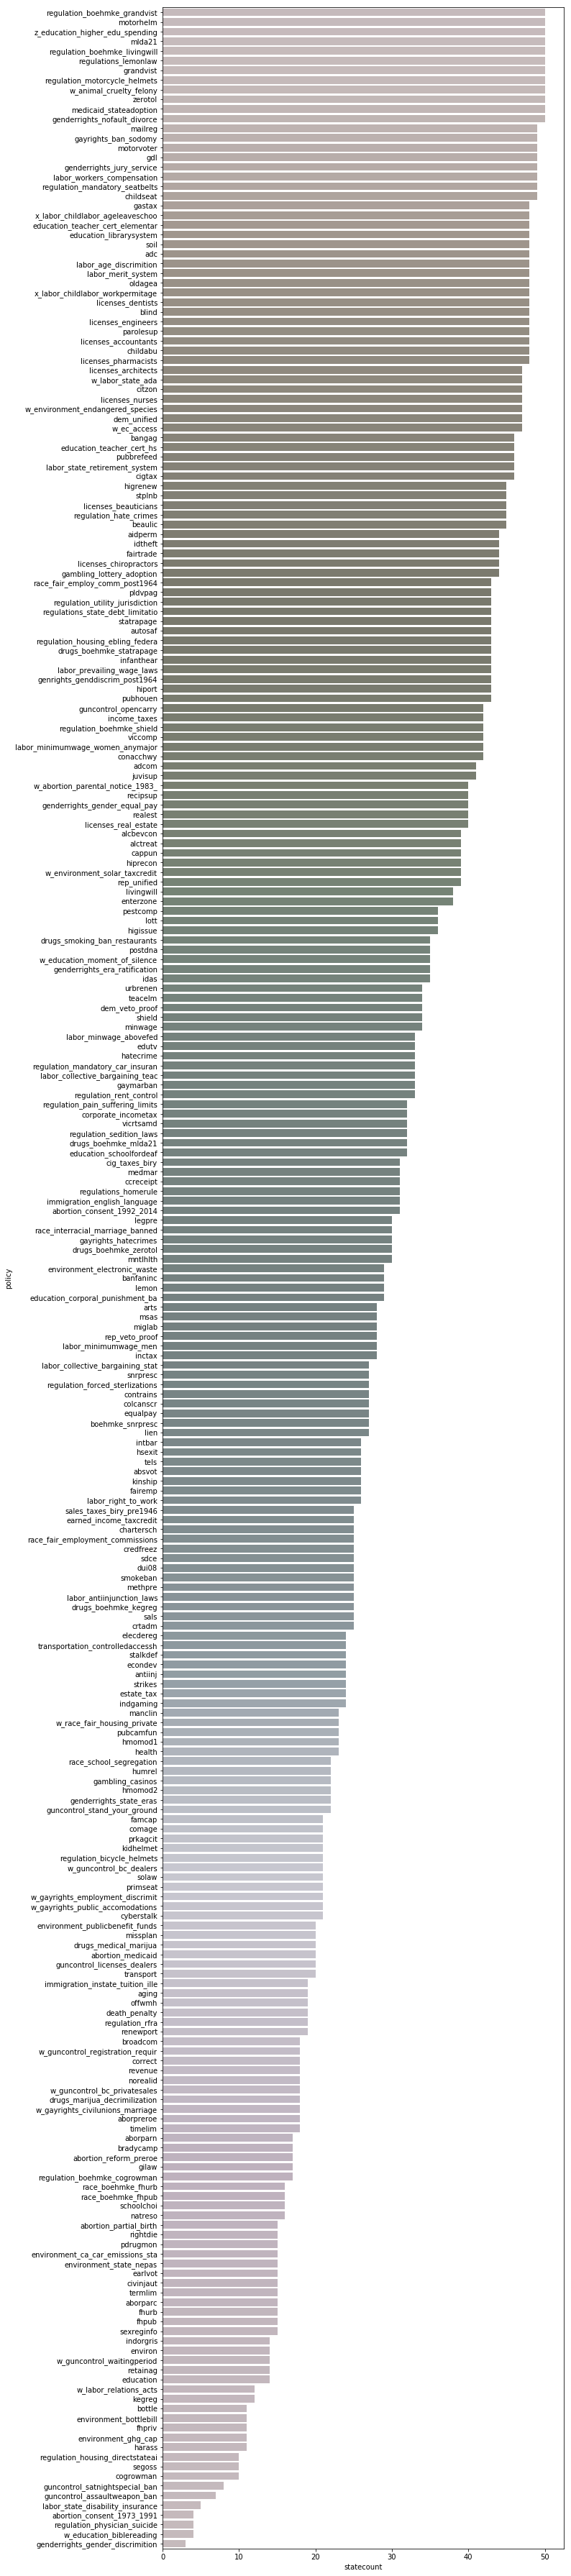

In [9]:
print "\n|   " + str(num_bin_policies) + " policy issues is still a big number.  The plot below shows the number of "
print "|   states that adopted each one. Then we'll cherry pick a few to look at.\n"
print "|   It seems like it would be interesting to ask another question as well - which states adopted the most"
print "|   policies?  But:"
print "|   A) the policies are not marked as being either liberal or conservative in nature, so the total counts"
print "|      might say something about how active the states were but would be difficult to interpret otherwise."
print "|   B) many of the columns break down policy choices by era - say, before and after a certain court"
print "|      decision - which could also make the counts misleading, as there can be two columns covering"
print "|   the same issue.\n"
print ".... working ...\n"

# popularity will hold counts of implementation of policies by state
dflist = ['year', 'st']
dflist.extend(policy_actions.name.tolist())
popularity = pd.DataFrame(index=range(0), columns=['policy', 'statecount'])

# counting the number of states that have adopted each policy (at any time)
for pa in policy_actions.name:
    tearoff = data[dflist].set_index('st')
    tearoff[pa] = tearoff[pa].astype('float')
    tearoff = tearoff[tearoff[pa] > 0]
    statelist = tearoff.index.unique()
    tearoff.drop(tearoff.index, inplace=True) # getting it out of memory
    popularity = popularity.append({'policy': pa, 'statecount':len(statelist)}, ignore_index=True)

popularity.sort_values('statecount',ascending=False, inplace=True)

plt.figure(figsize=(10,65))
sns.barplot(x="statecount", y="policy", data=popularity, saturation=.1);


                               ***** EXPLORING ******


|    Let's look at Childseat Safety Laws.  Who adopted them and when?
|    According to this site (https://saferide4kids.com/blog/the-general-history-of-car-seats/),
|    Tennessee adopted the first child seat safety law in 1979. This data differs from that,
|    but it may be an implementation date rather than a passage date.


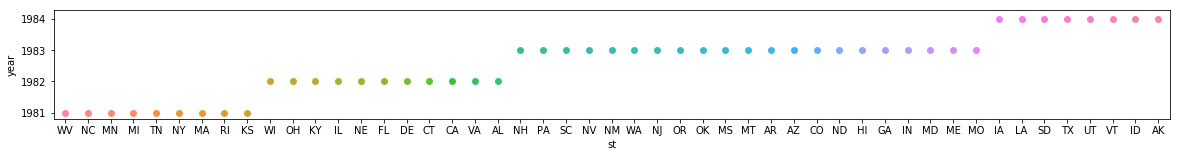

In [10]:
print "\n                               ***** EXPLORING ******\n"
print "\n|    Let's look at Childseat Safety Laws.  Who adopted them and when?"
print "|    According to this site (https://saferide4kids.com/blog/the-general-history-of-car-seats/),"
print "|    Tennessee adopted the first child seat safety law in 1979. This data differs from that,"
print "|    but it may be an implementation date rather than a passage date."

#print data[['year','childseat']][data.st == 'CA']
childseat = policy_table('childseat', 'adoption')
#print childseat
plt.figure(figsize=(20,2))
sns.stripplot(x='st', y='year', size=7, data=childseat);


|    When did Sodomy Bans begin?

   st  gayrights_ban_sodomy  year
0  AK                   1.0  1962
1  ND                   1.0  1962
2  NE                   1.0  1962
3  NH                   1.0  1962
4  NJ                   1.0  1962

|    No, all the states did not adopt sodomy bans in 1962.  The data begins in 1962 across the board 
|    because, prior to that, sodomy was illegal in all 50 states.  What the data is really showing, in 
|    this case, is the sequence of repeals, not the sequence of adoptions. So here are those repeals.


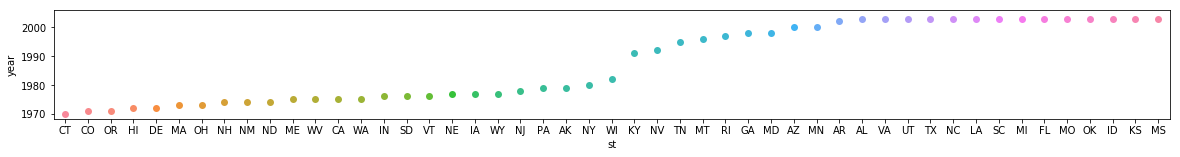

In [11]:
print "\n|    When did Sodomy Bans begin?\n"

ban_sodomy = policy_table('gayrights_ban_sodomy', 'adoption')
print ban_sodomy.head()

print "\n|    No, all the states did not adopt sodomy bans in 1962.  The data begins in 1962 across the board "
print "|    because, prior to that, sodomy was illegal in all 50 states.  What the data is really showing, in "
print "|    this case, is the sequence of repeals, not the sequence of adoptions. So here are those repeals."

ban_sodomy = policy_table('gayrights_ban_sodomy', 'repeal')
plt.figure(figsize=(20,2))
sns.stripplot(x='st', y='year', size=7, data=ban_sodomy)


|   Let's look at School Choice, something far fewer states have enacted.


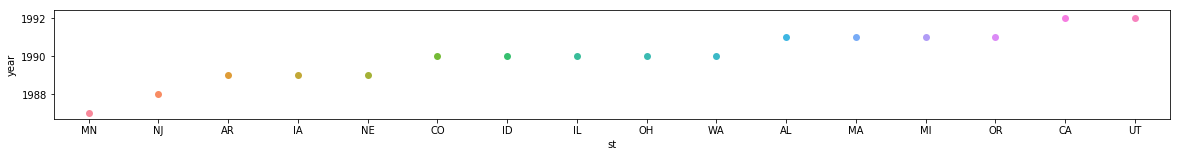

In [12]:
print "\n|   Let's look at School Choice, something far fewer states have enacted."
schoolchoi = policy_table('schoolchoi', 'adoption')
plt.figure(figsize=(20,2))
sns.stripplot(x='st', y='year', size=7, data=schoolchoi)

In [13]:
print "\n|   Is there a repeal profile on School Choice?\n"
schoolchoi = policy_table('schoolchoi', 'repeal')
print schoolchoi.head()

print "\n|   The data ends in 2010 for this column, but I suspect that's only because the study from which "
print "|   MSU got the data was done in 2012.  A lot has happened in this area since then, but I don't think "
print "|   there have been any repeals. In this case, then, the termination of a data block before the end of"
print "|   the file does not indicate a repeal."


|   Is there a repeal profile on School Choice?

   st  year  schoolchoi
0  AL  2010         1.0
1  AR  2010         1.0
2  CA  2010         1.0
3  CO  2010         1.0
4  IA  2010         1.0

|   The data ends in 2010 for this column, but I suspect that's only because the study from which 
|   MSU got the data was done in 2012.  A lot has happened in this area since then, but I don't think 
|   there have been any repeals. In this case, then, the termination of a data block before the end of
|   the file does not indicate a repeal.



|   On the subject of education, here's School Segregation.  What happened in CA in 1942?
|   For one thing, LA was a attacked by a UFO: 
|           http://www.huffingtonpost.com/jason-apuzzo/the-time-a-ufo-invaded-lo_b_6749734.html
|   It's more likely, though, that this policy change had something perversely to do with the war.


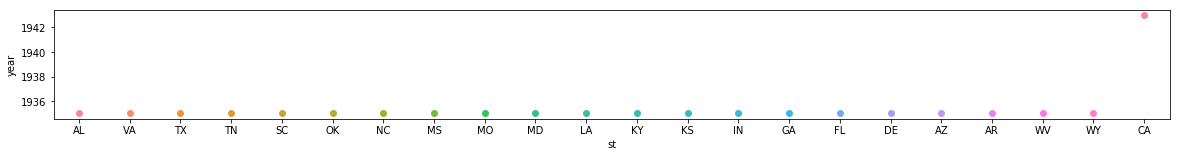

In [14]:
print "\n|   On the subject of education, here's School Segregation.  What happened in CA in 1942?"
print "|   For one thing, LA was a attacked by a UFO: "
print "|           http://www.huffingtonpost.com/jason-apuzzo/the-time-a-ufo-invaded-lo_b_6749734.html"
print "|   It's more likely, though, that this policy change had something perversely to do with the war."
schoolseg = policy_table('race_school_segregation', 'adoption')
plt.figure(figsize=(20,2))
sns.stripplot(x='st', y='year', size=7, data=schoolseg)



|   Now let's see when those segregation policies were abandoned.  CA remembered itself in 1946, but
|   most of these are southern states engaged in a completely different drama.  Still, it's interesting
|   that CA, IN and AZ provide a small leading indicator of a coming national change.


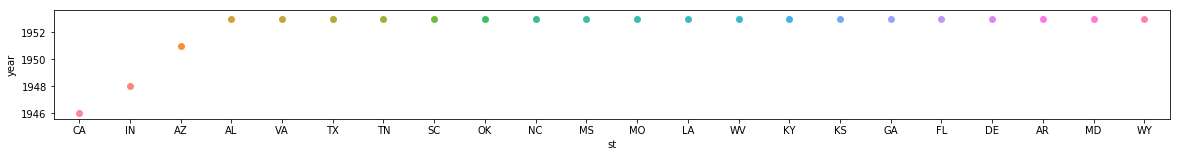

In [15]:
print "\n|   Now let's see when those segregation policies were abandoned.  CA remembered itself in 1946, but"
print "|   most of these are southern states engaged in a completely different drama.  Still, it's interesting"
print "|   that CA, IN and AZ provide a small leading indicator of a coming national change."
schoolseg = policy_table('race_school_segregation', 'repeal')
plt.figure(figsize=(20,2))
sns.stripplot(x='st', y='year', size=7, data=schoolseg)


|   The Right To Die.  This is NOT assisited suicide legislation, which has only been passed
|   in many of these states in the last couple of years.  It may be about court cases being 
|   brought, which did happen in CA in 1983, or it may be about removing people from artificial life
|   support. 

|   http://www.ncll.org/liberty-centers/center-for-life-defense/cld-articles/57-how-the-right-to-die-came-to-america

|   In 1986, Elizabeth Bouvia was granted the right to refuse force feeding on an appeal of a case that
|   she first lost in 1983.  The timeline below is not clear to me.

|   http://www.finalexit.org/chronology_right-to-die_events.html


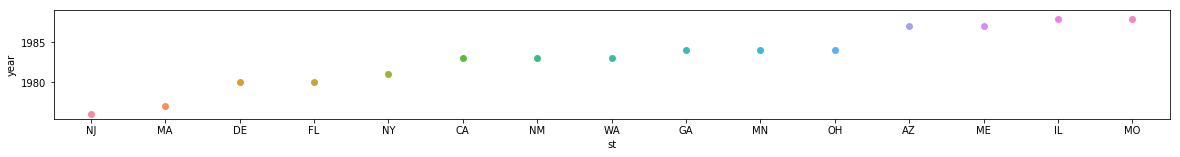

In [16]:
print "\n|   The Right To Die.  This is NOT assisited suicide legislation, which has only been passed"
print "|   in many of these states in the last couple of years.  It may be about court cases being "
print "|   brought, which did happen in CA in 1983, or it may be about removing people from artificial life"
print "|   support. \n"
print "|   http://www.ncll.org/liberty-centers/center-for-life-defense/cld-articles/57-how-the-right-to-die-came-to-america\n"
print "|   In 1986, Elizabeth Bouvia was granted the right to refuse force feeding on an appeal of a case that"
print "|   she first lost in 1983.  The timeline below is not clear to me.\n"
print "|   http://www.finalexit.org/chronology_right-to-die_events.html"

rightdie = policy_table('rightdie', 'adoption')
plt.figure(figsize=(20,2))
sns.stripplot(x='st', y='year', size=7, data=rightdie)


|   One more.  On the subject of inevitability, State Income Taxes.

|   Here's the paper this data comes from:
|           http://cwarshaw.scripts.mit.edu/papers/CaugheyWarshaw_Policy_Dynamics150303.pdf
|   I'd like to direct your attention to page 14 of that paper, because I will soon be committing 
|   plotting crimes of a similar nature and I want to be in good company.



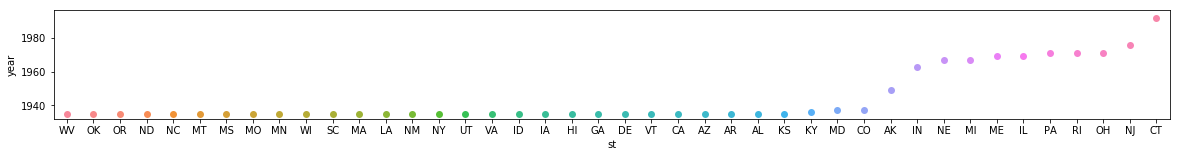

In [17]:
print "\n|   One more.  On the subject of inevitability, State Income Taxes.\n"
print "|   Here's the paper this data comes from:"
print "|           http://cwarshaw.scripts.mit.edu/papers/CaugheyWarshaw_Policy_Dynamics150303.pdf"
print "|   I'd like to direct your attention to page 14 of that paper, because I will soon be committing "
print "|   plotting crimes of a similar nature and I want to be in good company.\n"
tax = policy_table('income_taxes', 'adoption')
plt.figure(figsize=(20,2))
sns.stripplot(x='st', y='year', size=7, data=tax)


|    To put all of this in context, let's take a look at political swings within state legislatures.
|    The plot below shows republicans as a percentage of representatives for each state, over time.
|    (my plot crime)

|    In spite of the mess, there are some worthwhile observations to make from this plot.  One is that
|    it appears to be often the case that leftward and rightward shifts are broad based national events.
|    Sometimes that's true in a given year and other times over a period of years.

|    Looking at the mean, we've been a left-of-center country, on the whole, for 80+ years, though the
|    trend since 1980 has been steadily to the right. It would be interesting to see these values
|    adjusted for population, for correlation and for nearness.

|    It appears that the wide standard deviation of the post-war years gave way in the 70s to narrower
|    swings.  There was also, initially, a move to the left in the 60s and 70s. It was after this shift, 
|    for 

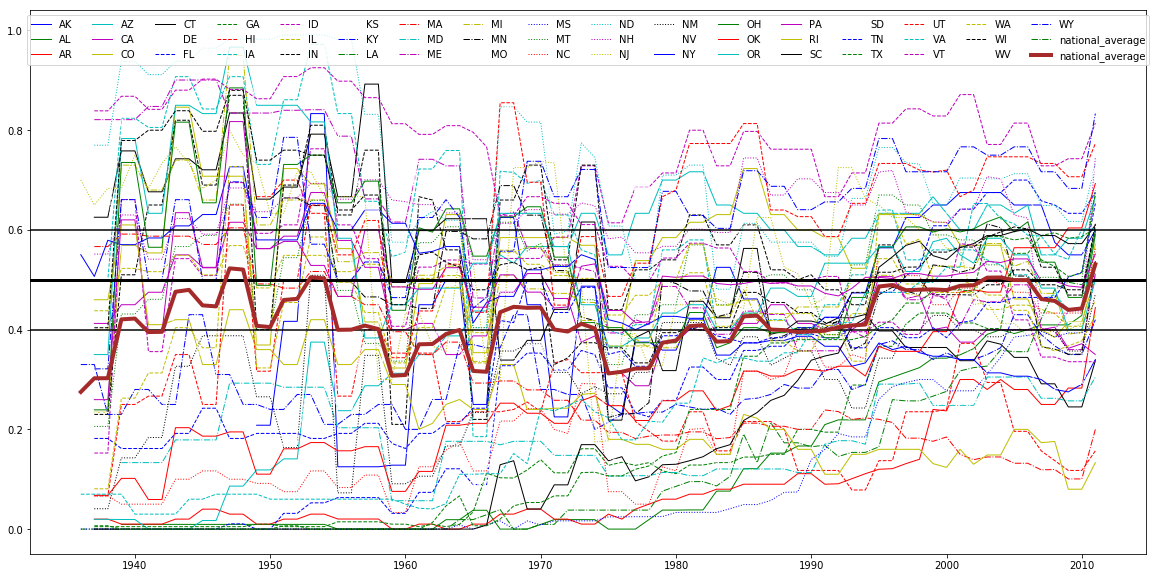

In [20]:
print "\n|    To put all of this in context, let's take a look at political swings within state legislatures."
print "|    The plot below shows republicans as a percentage of representatives for each state, over time."
print "|    (my plot crime)\n"

print "|    In spite of the mess, there are some worthwhile observations to make from this plot.  One is that"
print "|    it appears to be often the case that leftward and rightward shifts are broad based national events."
print "|    Sometimes that's true in a given year and other times over a period of years.\n"

print "|    Looking at the mean, we've been a left-of-center country, on the whole, for 80+ years, though the"
print "|    trend since 1980 has been steadily to the right. It would be interesting to see these values"
print "|    adjusted for population, for correlation and for nearness.\n"

print "|    It appears that the wide standard deviation of the post-war years gave way in the 70s to narrower"
print "|    swings.  There was also, initially, a move to the left in the 60s and 70s. It was after this shift, "
print "|    for example, that most sodomy laws were repealed.  The center of gravity has since shifted more to the "
print "|    right, with the early 90s appearing as a almost a fulcrum moment, a highpoint for centrism, as in "
print "|    the period of the late 80s and early 90s nearly all the lines are moving towards the center. \n"

print "|    One possible explanation for the change in variance that began in the 70s is redistricting.  In two "
print "|    cases heard by the supreme court in 1964, (Wesberry v. Sanders & Reynolds v. Sims), the court found "
print "|    that states had an obligation to redraw districts after every census.  About a decade later is when "
print "|    we appear to see the effects of that emerge, as the parties both learned to use the redistricting "
print "|    process to create \"safe\" districts, dramatically reducing the volatility of state house "
print "|    distributions.\n"

print "|    That doesn't mean there aren't still changes in the political mix, but those changes are now"
print "|    more gradual.  In light of that, the very strong shift to the right in recent years would seem"
print "|    to indicate something fundamental about the electorate.\n"

browntext("Republicans as a percentage of state representatives")

data.hs_rep_in_sess = data.hs_rep_in_sess.astype('float')
data.hs_dem_in_sess = data.hs_dem_in_sess.astype('float')
p = data[['st','year','hs_rep_in_sess', 'hs_dem_in_sess']]
p = p.dropna(axis=0, how='any')
p['chartable'] = (p.hs_rep_in_sess/(p.hs_rep_in_sess + p.hs_dem_in_sess))

p = p.pivot(index='year', columns='st', values='chartable')
p['national_average'] = p.mean(axis=1)
#p['adjusted_for_volumne'] = 
states = p.columns
mycolors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
markers = ['.', ',', 'o', 'v', '^', '<', '>', 'd']
linestyles = ['solid', 'dashed', 'dashdot', 'dotted','-', '--', '-.', ':']

fig, ax = plt.subplots(figsize=(20, 10))
ic = 0
lc = 0
for state in states:
    ax.plot(p.index, p[state], mycolors[ic], label=state, linewidth=1, linestyle=linestyles[lc]) 
    ic = ic + 1
    if ic > 7: 
        ic = 0
        lc = lc + 1
    if lc > 7: lc = 0
ax.axhline(y=0.5, color='k', linestyle='-', linewidth=3)
ax.axhline(y=0.4, color='k', linestyle='-', linewidth=1.5)
ax.axhline(y=0.6, color='k', linestyle='-', linewidth=1.5)
ax.plot(p.index, p.national_average, color='brown', linestyle='-', linewidth=4)
ax.legend(loc='upper center', ncol=17)
plt.show(block=True)


|   Redistricting is not the whole story of change starting in the 70s. Income distributions 
|   also began to shift, starting around 1980 and continuing to diverge as time went on, with the 
|   top 10 percent of earners earning as much as 60% of all state income in some cases.

|   The bursting of various bubbles (dot coms in 2000 and real estate/everything else in 2008) took
|   a toll on these inequalities. This suggests that asset holdings have something to do with this 
|   phenomenon.  The same thing is also visible in the 1987 stock market crash and during the 
|   recession in the 70s.



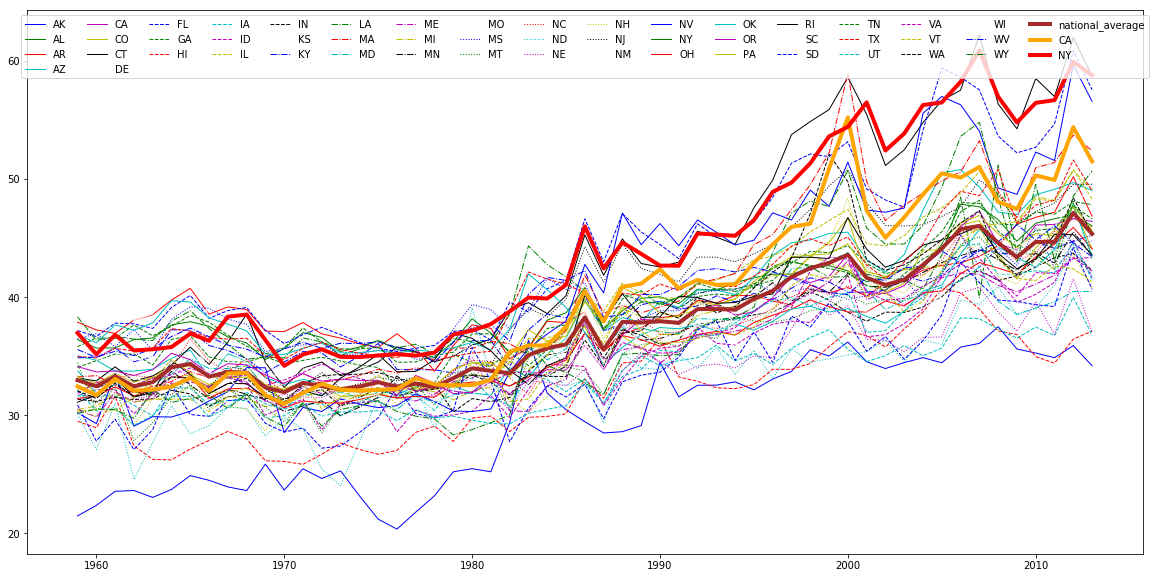

In [19]:
print "\n|   Redistricting is not the whole story of change starting in the 70s. Income distributions "
print "|   also began to shift, starting around 1980 and continuing to diverge as time went on, with the "
print "|   top 10 percent of earners earning as much as 60% of all state income in some cases.\n"

print "|   The bursting of various bubbles (dot coms in 2000 and real estate/everything else in 2008) took"
print "|   a toll on these inequalities. This suggests that asset holdings have something to do with this "
print "|   phenomenon.  The same thing is also visible in the 1987 stock market crash and during the "
print "|   recession in the 70s.\n"

browntext("Share of income going to the top 10%")

top10 = numeric_pivot('incshare_top10')
fig, ax = plt.subplots(figsize=(20, 10))
ic = 0
lc = 0
for state in data.st.unique():
    ax.plot(top10.index, top10[state], mycolors[ic], label=state, linewidth=1, linestyle=linestyles[lc]) 
    ic = ic + 1
    if ic > 7: 
        ic = 0
        lc = lc + 1
    if lc > 7: lc = 0
ax.plot(top10.index, top10['national_average'], color='brown', linestyle='-', linewidth=4)
ax.plot(top10.index, top10['CA'], color='orange', linestyle='-', linewidth=4)
ax.plot(top10.index, top10['NY'], color='red', linestyle='-', linewidth=4)
ax.legend(loc='upper center', ncol=17)
plt.show(block=True)


|   Here's a 2013 snapshot (blue bars).  It's not surprising to see CA, NY and MA 
|   in the top 7, but WY?. I wonder how much Ted Turner has to do with that?

|   The orange bars below show 1969 levels for comparison.


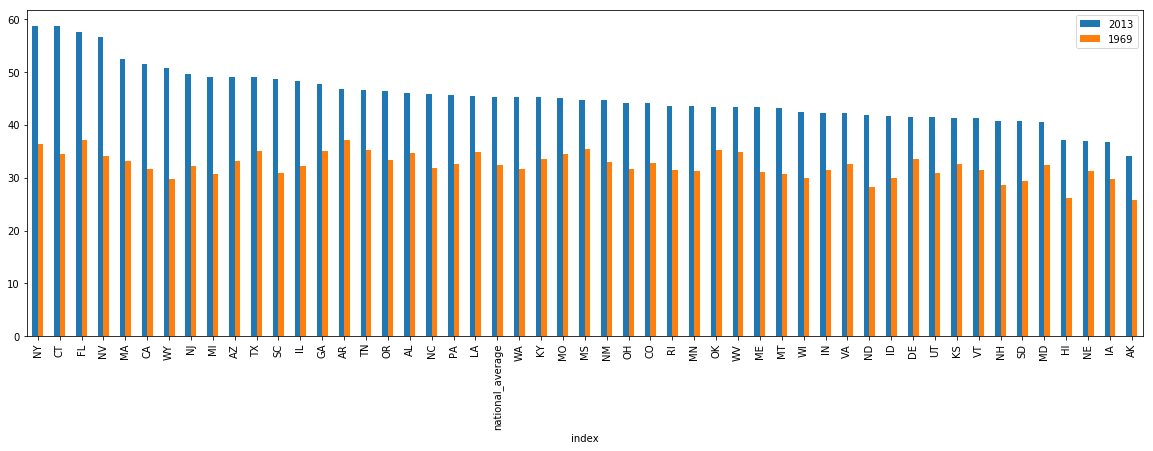

In [21]:
print "\n|   Here's a 2013 snapshot (blue bars).  It's not surprising to see CA, NY and MA "
print "|   in the top 7, but WY?. I wonder how much Ted Turner has to do with that?\n"
print "|   The orange bars below show 1969 levels for comparison."

browntext("Income inequality in 2013 vs 1969")

thirteen_top10 = top10.loc['2013'].sort_values(ascending=False).head(51)
sixtynine_top10 = top10.loc['1969'].sort_values(ascending=False).head(51)

change = pd.concat([thirteen_top10, sixtynine_top10], axis=1).reset_index()
change.set_index('index').sort_values('2013', ascending=False).plot.bar(figsize=(20,6))


|   Maybe there really is a Ted Turner effect.  This plot shows the state house
|   distributions for the 7 most unequal states based on the top 10% of earners.

|   The politics of Wyoming and Florida do not resemble the politics of the others, where 
|   presumably the wealth inequality is more a function of businesses operating in those 
|   states and less a function of a few very wealthy people simply happening to live there.



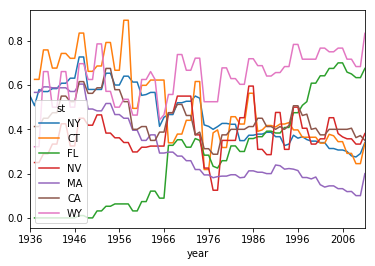

In [22]:
print "\n|   Maybe there really is a Ted Turner effect.  This plot shows the state house"
print "|   distributions for the 7 most unequal states based on the top 10% of earners.\n"


print "|   The politics of Wyoming and Florida do not resemble the politics of the others, where "
print "|   presumably the wealth inequality is more a function of businesses operating in those "
print "|   states and less a function of a few very wealthy people simply happening to live there.\n"

browntext("State house distribution for top 7 states where the top 10% of earners make the largest share of the state's income")

fliers = thirteen_top10.head(7).index.tolist()
p[fliers].plot(figsize=(6,4))


|   Let's test that intuition a little further.  In this plot, I resorted the states by
|   subtracting the share of earnings going to the top 1% from the share going to the top 10% in 
|   an effort to focus on the people just below the very top (princes vs kings), who are more likely 
|   to live in the place where their income is generated.  This should highlight the states where the 
|   top income earners are members of the professional class, rather than unicorn owning entrepreneurs. 
|   Let's call them the princely states.  In these states, political trends are more convergent.



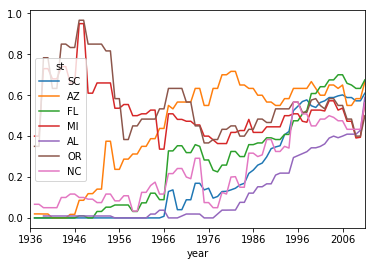

In [30]:
print "\n|   Let's test that intuition a little further.  In this plot, I resorted the states by"
print "|   subtracting the share of earnings going to the top 1% from the share going to the top 10% in "
print "|   an effort to focus on the people just below the very top (princes vs kings), who are more likely "
print "|   to live in the place where their income is generated.  This should highlight the states where the "
print "|   top income earners are members of the professional class, rather than unicorn owning entrepreneurs. "
print "|   Let's call them the princely states.  In these states, political trends are more convergent.\n"

browntext("Political distribution in princely states - top 7 states for inequality excluding effect of unicorns.")

# top 1% of earners by staet
top1 = numeric_pivot('incshare_top1')
# current snapshot of top1 by state
thirteen_top1_by_state = top1.loc['2013'].sort_index(ascending=True).head(51)
# current snapshot of top10 by state
thirteen_top10_by_state = top10.loc['2013'].sort_index(ascending=True).head(51)

# These tables show the percentage of a states earnings that go those percentages of people
# so if you subtract top1 from top10, you should get the percentage of earnings that go
# to the people who are near the top but not quite at the top.  The princes, rather than the kings.
# The basic intuition is that, in a state like Wyoming, one person can make the whole state
# appear very unequal because the population overall is relatively poor. So if we remove the wealth
# of the people at the very top, we should see states with more broadly based wealth
princely = thirteen_top10_by_state - thirteen_top1_by_state

subfliers = princely.sort_values(ascending=False).head(7).index.tolist()
p[subfliers].plot(figsize=(6,4))


|   I also wondered if population growth was stronger or more consistent in these
|   professional class states.  The plot on the left shows population trends in the
|   most unequal states in the group of professional class states from above, while
|   the plot on the right shows the population trends of the least unequal states from
|   the same list. (notice that, with the top 1% of earners removed from the calculation, 
|   Wyoming is now among the least unequal states.)



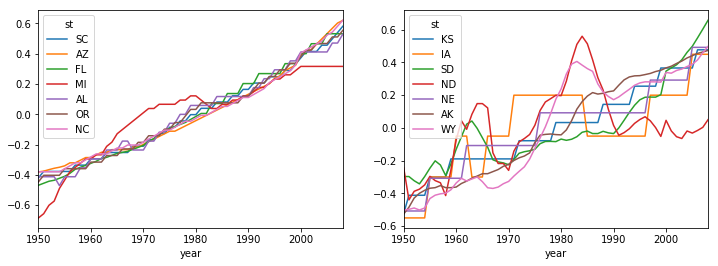

In [31]:
print "\n|   I also wondered if population growth was stronger or more consistent in these"
print "|   professional class states.  The plot on the left shows population trends in the"
print "|   most unequal states in the group of professional class states from above, while"
print "|   the plot on the right shows the population trends of the least unequal states from"
print "|   the same list. (notice that, with the top 1% of earners removed from the calculation, "
print "|   Wyoming is now among the least unequal states.)\n"

fig, axs = plt.subplots(1,2, figsize=(12,4))

#df['korisnika'].plot(ax=axs[0])
#df['osiguranika'].plot(ax=axs[1])

# make a population table that is normalized for easy comparison
totpop = numeric_pivot('poptotal')
df_norm = (totpop - totpop.mean()) / (totpop.max() - totpop.min())

# get the LEAST unequal states from the princely class states
# so we're looking at the most and least unequal from the same list
subfliers_tail = princely.sort_values(ascending=False).tail(7).index.tolist()

df_norm[subfliers].plot(ax=axs[0])
df_norm[subfliers_tail].plot(ax=axs[1])
